In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import waterfall_chart

## Wczytanie danych

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

## Przygotwanie zmiennych

Najpierw konwertujemy odpowiedź `S1` na zmienną binarną, gdzie 1 odpowiada informacji `Yes, I am Married`

In [3]:
df['y'] = 1 - df['S1'].cat.codes

### Wybrane zmienne

Do modelu wybrałem następujące zmienne  
1) kategoryczne:  
  a) `Q23` - Between you and [Partner name], who earned more income in 2016,  
  b) `Q28` - Did your parents know [Partner name]’s parents before you met [Partner name]?,  
2) uporządkowane:  
  a) `ppp20072` - Q27: How often do you attend religious services?,  
  b) `w6_how_many` - How many Different people besides [Partner name] have you met for dating, or rom   

Wszystkie zmienne są zakodowane przez kategorię, które odkoduję.

In [4]:
df = df.dropna(subset=['Q23', 'Q28', 'ppp20072', 'w6_how_many'])

In [5]:
X = df[['Q23', 'Q28', 'ppp20072', 'w6_how_many']].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

Zostało nam 225 obserwacji co oznacza, że nie ma sensu uczyć modelu o dużej pojemności. Z tego powodu wybrałem las losowy o 25 drzewach i maksymalnej głębokości 3.

Stworzymy dodatkowo słowniki do zmiennych kategorycznych by łatwiej odwikłać potem kategorię.

In [7]:
d_ppp20072 = dict(enumerate(df['ppp20072'].cat.categories))
d_w6_how_many = dict(enumerate([cat.split(".")[0] for cat in df['w6_how_many'].cat.categories]))

In [8]:
d = {
    'ppp20072': d_ppp20072,
    'w6_how_many': d_w6_how_many
}

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Budowa modeli

Do wybranego problemu podejdę budując 2 modele - random forest i SVM, chcąc dostać mało skorelowane predykcję.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rf = RandomForestClassifier(n_estimators=25, max_depth=4)

In [21]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
from sklearn.svm import SVC

In [39]:
svc = SVC(probability=True)

In [40]:
svc.fit(X_train,y_train)

C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Metoda petrurbacji i spadku zmiennej celu dla każdej zmiennej.

Jako funkcję celu przyjmę polę pod krzywą roc.

In [63]:
from sklearn.metrics import roc_auc_score

In [64]:
variable_importances = pd.DataFrame()

In [65]:
models = [rf, svc]

In [66]:
for model in models:
    normal_loss = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    for col in X_train.columns:
        losses_inc = []
        for i in range(100):
            X_p = X_test.copy()
            X_p.loc[:, col] = np.random.permutation(X_p[col])
            y_pred = model.predict_proba(X_p)[:,1]
            new_loss = roc_auc_score(y_test, y_pred)
            loss_inc = new_loss - normal_loss
            losses_inc.append(loss_inc)
        variable_importances = variable_importances.append(pd.DataFrame(
            {"model":repr(model).split("(")[0],
             "loss_inc": np.mean(losses_inc),
             "variable":col},  index=[i]))

## Wyplotowanie wyników analizy ważności zmiennych metodą perturbacji

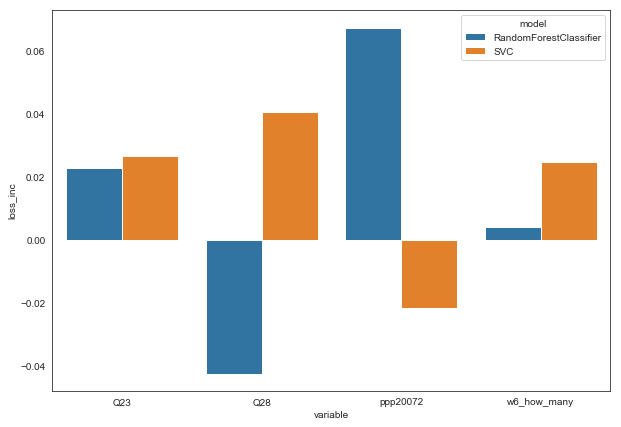

In [67]:
plt.figure(figsize=(10,7))
sns.barplot(x='variable', y='loss_inc', hue='model', data=variable_importances, ci=None)

Jak widać ważność cech jest bardzo rozjechana, modele zgadzają się jedynie co do ważności Q23, gdzie po usunięciu tej zmiennej spadek funkcji celu jest podobny.  
Dodatkowo niektóre zmienne mają ten wskaźnik ujemny, co oznacza że prawdopodobnie model jest przeuczony, lub jest wystarczająca wielkość próbki uczącej. Można by spróbować usunąć te zmienne i zbadać performance takiego modelu.

## PDP plot

Uznałem, że najbardziej różniącą oba modele zmienną jest `Q28`, jednak jest to zmienna, która przyjmuje tylko 3 wartości więc jej pdp nie będzie tak ciekawy jak pdp plot zmiennej `ppp200072`

### PDP plot dla random forestu

In [130]:
model = models[0]

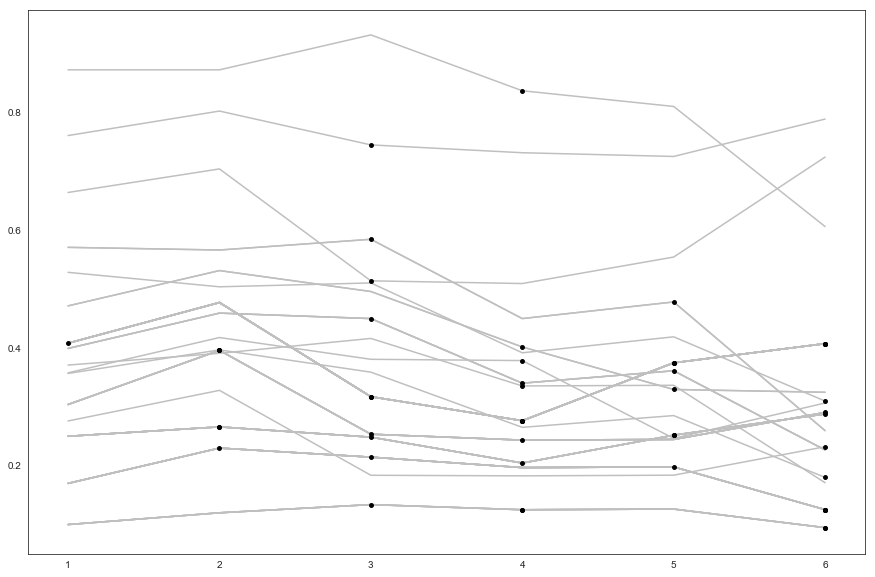

In [131]:
fig, axes = plt.subplots(1, 1, figsize=(15,10))
for i, row in X_test.iterrows():
    single_row_preds = []
    for val in sorted(X_test['ppp20072'].unique()):
        row_new = row.copy()
        row_new[column] = val
        single_row_preds.append(model.predict_proba(row_new.values.reshape(1,-1))[:,1])
    axes.plot(sorted(X_test['ppp20072'].unique()), single_row_preds, color = '0.75', alpha=1)
    axes.scatter(row['ppp20072'], model.predict_proba(row.values.reshape(1,-1))[:,1], 
                       c = 'black', s = 15, zorder = 10)
    

Jak widać relacja wartości zwracanej przez model a zmiennej `ppp20072` jest dość stała, im wyższa wartość tej zmiennej tym mniejsze p-stwo zmiennej celu.

### PDP plot dla SVM

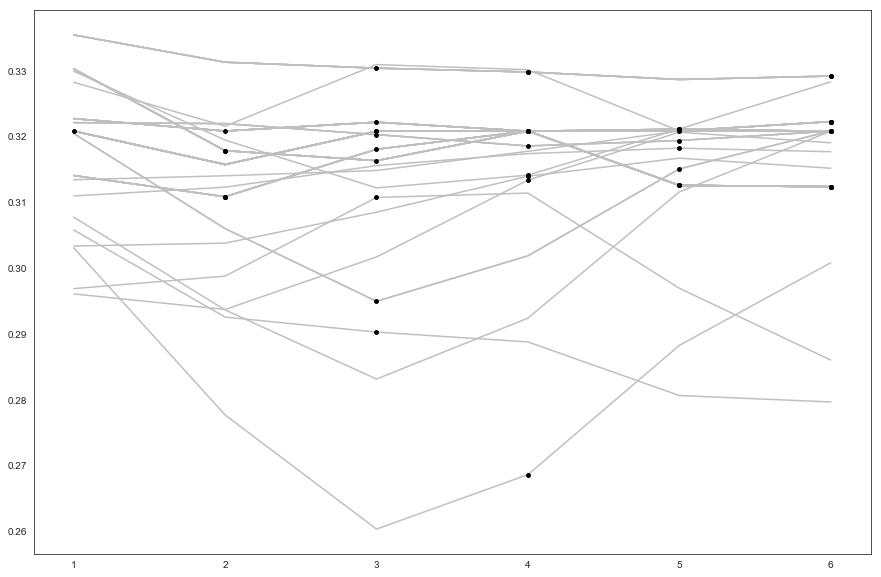

In [133]:
model = models[1]
fig, axes = plt.subplots(1, 1, figsize=(15,10))
for i, row in X_test.iterrows():
    single_row_preds = []
    for val in sorted(X_test['ppp20072'].unique()):
        row_new = row.copy()
        row_new[column] = val
        single_row_preds.append(model.predict_proba(row_new.values.reshape(1,-1))[:,1])
    axes.plot(sorted(X_test['ppp20072'].unique()), single_row_preds, color = '0.75', alpha=1)
    axes.scatter(row['ppp20072'], model.predict_proba(row.values.reshape(1,-1))[:,1], 
                       c = 'black', s = 15, zorder = 10)

Jak widać w przypadku SVM mamy do czynienia z relacją, której wykres bardziej przypomina parabolę o dodatnim współczyniku przy $x^{2}$.

Różnica w obu pdp-plotach może być związana ze specykifacją modelu. Zmienna ta, patrząc ludzkim okiem nie powinna mieć takiej relacji w stostunku do zmiennej celu. Dlatego, ta zmienne lepiej działa dla Random Forestu, gdzie ta relacja jest dużo bardziej naturalna, co potwierdzają perturbartion plots.